# Intel Images Classification using ResNet

## Installing Dependencies

In [1]:
!pip install --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.7
    Uninstalling wandb-0.18.7:
      Successfully uninstalled wandb-0.18.7


## Import Library

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from wandb.integration.keras import WandbMetricsLogger
import wandb

In [ ]:
wandb.login(key="#")

# Data Preprocessing

## Load Dataset

In [4]:
class_names = os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")
print(len(class_names))

6


### Configuration

In [5]:
config = {
    "BATCH_SIZE" :32,
    "IMG_SIZE":150,
    "VAL_SPLIT":0.1,
    "EPOCHS":100,
    "PATIENCE":5
}

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    shuffle=True,
    seed=32,
    validation_split=config["VAL_SPLIT"],
    subset="training",
    interpolation="bilinear",
    verbose=True
)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_train/seg_train",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    seed=32,
    validation_split=config["VAL_SPLIT"],
    subset="validation",
    interpolation="bilinear",
    verbose=True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/intel-image-classification/seg_test/seg_test",
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=config["BATCH_SIZE"],
    image_size=(config["IMG_SIZE"],config["IMG_SIZE"]),
    interpolation='bilinear',
    verbose=True
)

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.


## Visualize Distribution

In [7]:

def get_data_distribution(dataset=[]):
  labels = []
  for data in dataset:
    for _,label in data:
      labels.extend(tf.argmax(label,axis=1).numpy())
  y, idx, count = tf.unique_with_counts(labels)
  return y, count



def visualize_data(class_data,count):
  plt.figure(figsize=(10,10))
  plt.bar(class_data,count,align="center")
  plt.tight_layout()
  plt.title("Class Distribution")
  plt.ylabel("Number of Data")
  plt.xlabel("Class in number")
  plt.show()


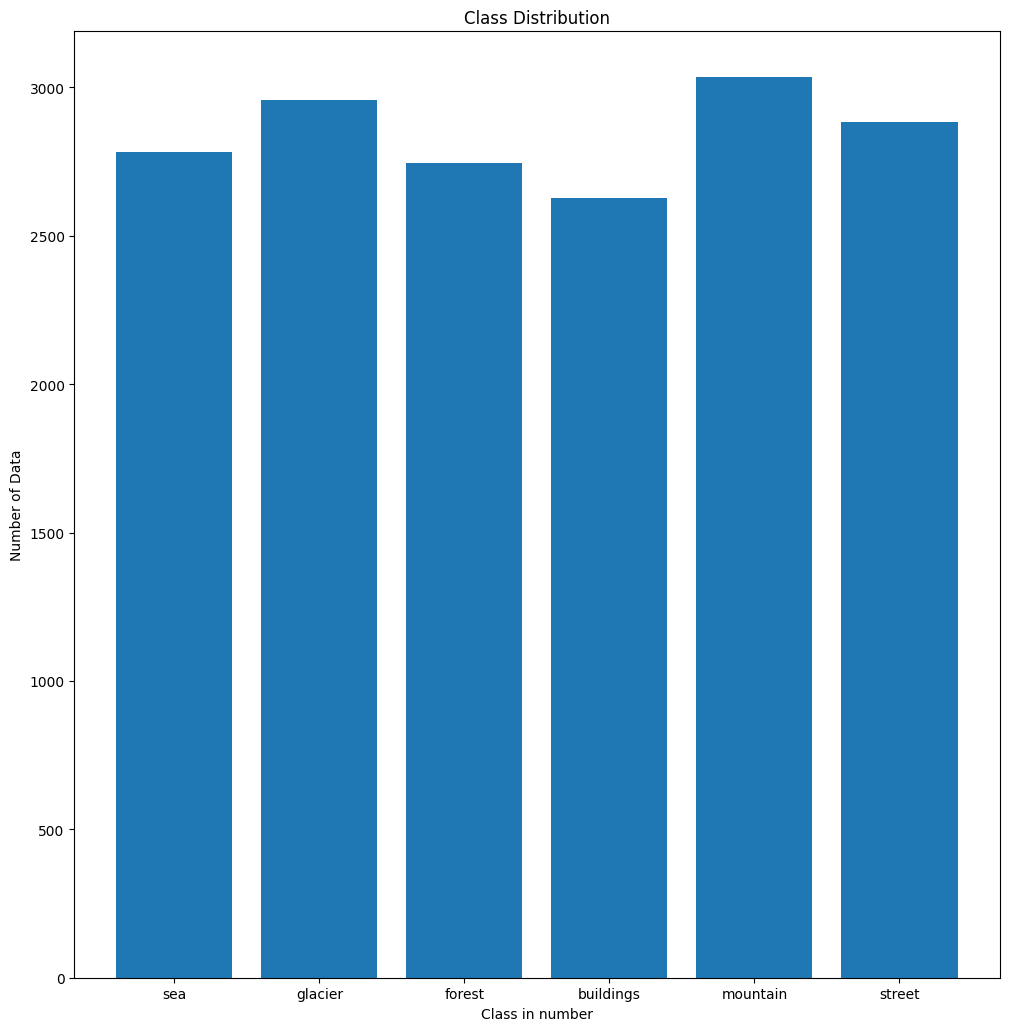

In [8]:
class_data, counts = get_data_distribution([train_data,valid_data,test_data])
visualize_data([class_names[cd] for cd in class_data],counts.numpy())

In [9]:
for i,_ in enumerate(class_data):
  print(f"{class_names[class_data[i]]} : {counts[i]}")

sea : 2784
glacier : 2957
forest : 2745
buildings : 2628
mountain : 3037
street : 2883


## Visualize Sample Image

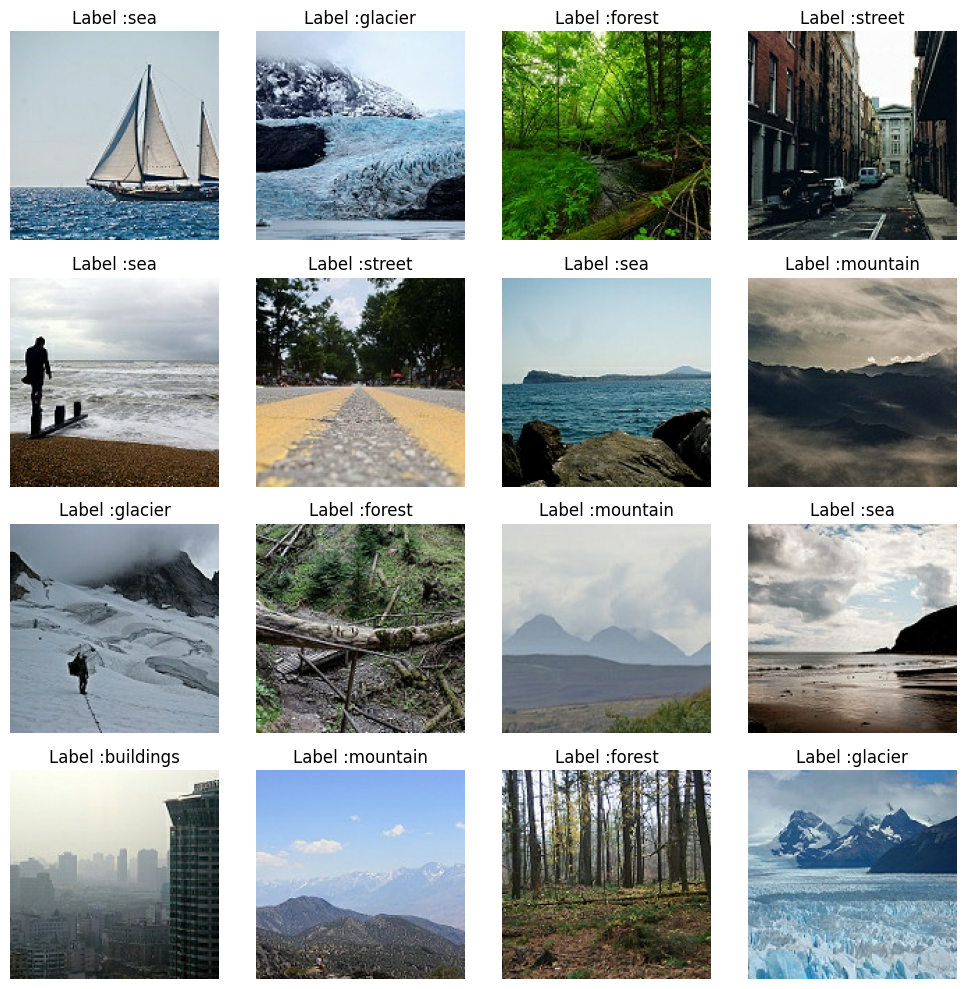

In [10]:
plt.figure(figsize=(10,10))
for img,label in train_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(f"Label :{class_names[tf.argmax(label[i])]}")
    plt.axis(False)
plt.tight_layout()
plt.show()

## Data Augmentation

### Flip Vertical

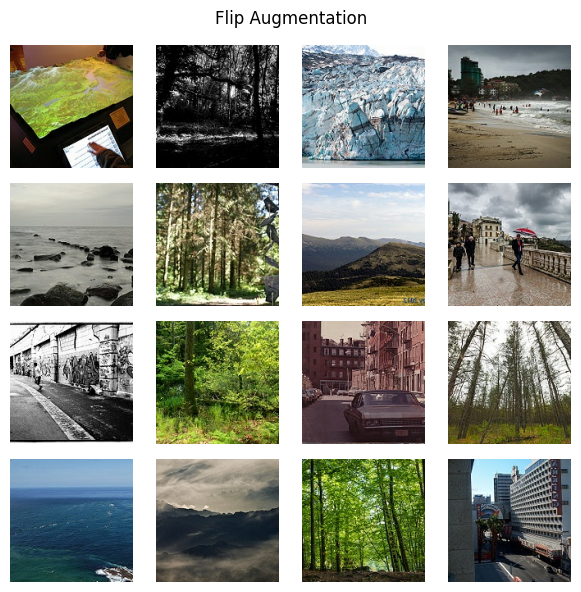

In [11]:
def img_flip_vertical(img):
    return tf.image.flip_left_right(img)


test_flip = (train_data.map(lambda img, label: img_flip_vertical(img)))
plt.figure(figsize=(6,6))
for img in test_flip.take(1):
    for num in range(16):
        ax = plt.subplot(4,4,num+1)
        plt.imshow((img[num].numpy()).astype("uint8"))
        plt.axis("off")  
plt.suptitle("Flip Augmentation")
plt.tight_layout()
plt.show()


### Random Contrast

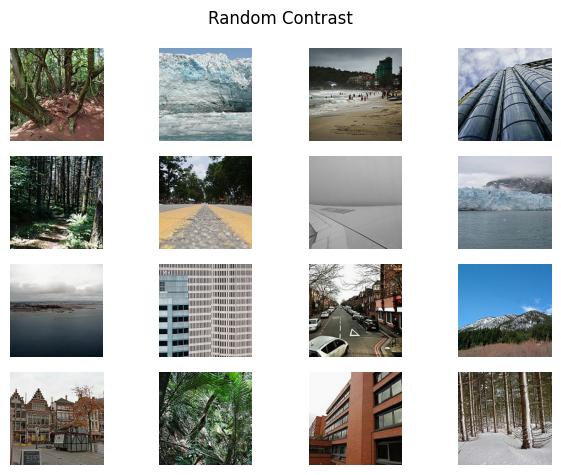

In [12]:
def img_random_contrast(img):
    return  tf.image.random_contrast(img, 0.95,1 )

test_random_contrast = (train_data.map(lambda img, label: img_random_contrast(img)))
for img in test_random_contrast.take(1):
    for num in range(16):
        ax = plt.subplot(4,4,num+1)
        plt.imshow((img[num].numpy()).astype("uint8"))
        plt.axis("off")  
plt.suptitle("Random Contrast")
plt.tight_layout()
plt.show()


### Random Brightness 

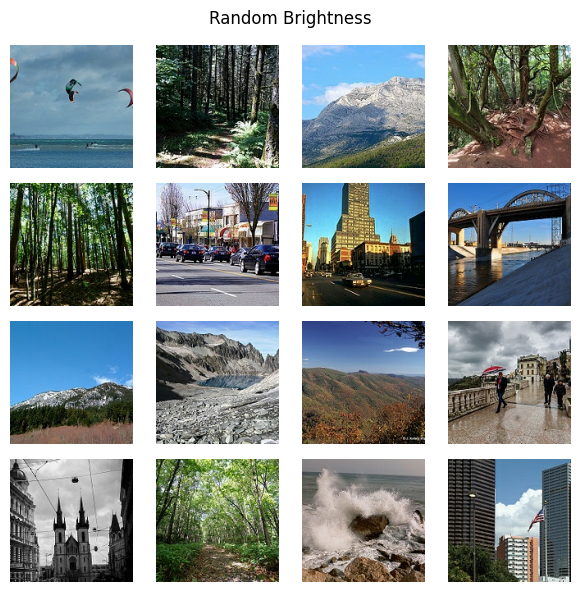

In [13]:
def img_random_brightness(img):
    return tf.image.random_brightness(img, .2)

test_random_brightness = (train_data.map(lambda img, label: img_random_brightness(img)))
plt.figure(figsize=(6,6))
for img in test_random_brightness.take(1):
    for num in range(16):
        ax = plt.subplot(4,4,num+1)
        plt.imshow((img[num].numpy()).astype("uint8"))
        plt.axis("off")  
plt.suptitle("Random Brightness")
plt.tight_layout()
plt.show()


### Random Hue

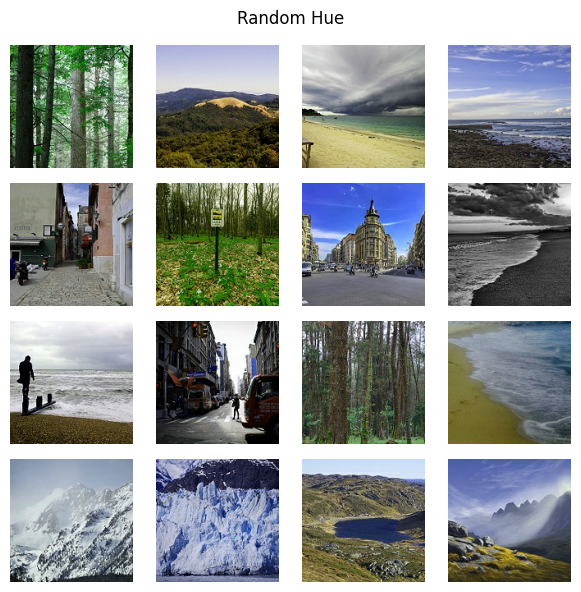

In [14]:
def random_hue(img):
    return tf.image.random_hue(img, 0.05)

test_random_hue = (train_data.map(lambda img, label: random_hue(img)))
plt.figure(figsize=(6,6))
for img in test_random_hue.take(1):
    for num in range(16):
        ax = plt.subplot(4,4,num+1)
        plt.imshow((img[num].numpy()).astype("uint8"))
        plt.axis("off")  
plt.suptitle("Random Hue")
plt.tight_layout()
plt.show()

In [15]:
def image_augmentation(img,label):
  img,label = normalize_img(img,label)
  img = img_flip_vertical(img)
  img = img_random_contrast(img)
  img = img_random_brightness(img)
  img = random_hue(img)
  return img,label

def normalize_img(img,label):
  img = tf.cast(img,tf.float32)/255.0
  return img,label

In [16]:
train_dataset = (
    train_data
    .map(lambda img, label: image_augmentation(img, label), num_parallel_calls=tf.data.AUTOTUNE)  
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE) 
)

valid_dataset = (
    valid_data
    .map(lambda img, label: normalize_img(img, label), num_parallel_calls=tf.data.AUTOTUNE)  
    .cache()  
    .prefetch(buffer_size=tf.data.AUTOTUNE)  
)

# Optimization for test_data
test_dataset = (
    test_data
    .map(lambda img, label: normalize_img(img, label), num_parallel_calls=tf.data.AUTOTUNE) 
    .prefetch(buffer_size=tf.data.AUTOTUNE) 
)


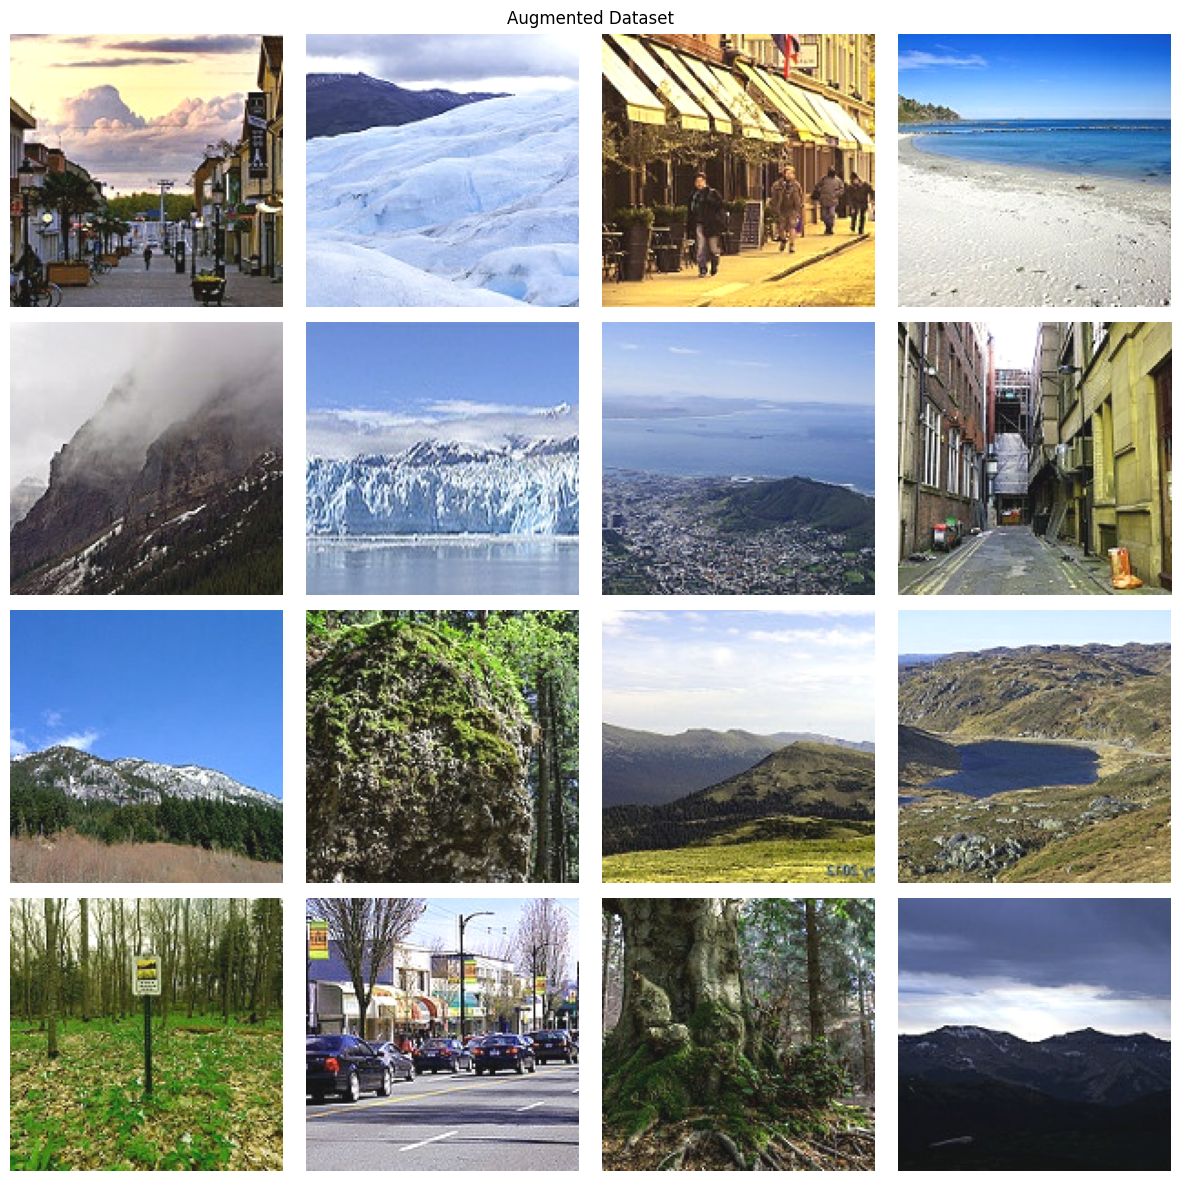

In [17]:
plt.figure(figsize=(12, 12))
for img, label in train_dataset.take(1):
    for num in range(16): 
        ax = plt.subplot(4, 4, num + 1)        
        img_to_display = (img[num].numpy() * 255).clip(0, 255).astype("uint8")
        plt.imshow(img_to_display)
        plt.axis("off")  
plt.suptitle("Augmented Dataset")
plt.tight_layout()
plt.show()


## Building Model ResNet

In [18]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn2 = tf.keras.layers.BatchNormalization()

        if downsample:
            self.downsample_conv = tf.keras.layers.Conv2D(filters, 1, strides=strides,kernel_regularizer=tf.keras.regularizers.L2(0.001))
            self.downsample_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.downsample:
            residual = self.downsample_conv(inputs)
            residual = self.downsample_bn(residual, training=training)
        x += residual
        return self.relu(x)


In [19]:
class BottleneckBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, downsample=False):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = tf.keras.layers.Conv2D(filters // 2, 1, strides=1, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters // 2, 3, strides=strides, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters, 1, strides=1, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

        if downsample:
            self.downsample_conv = tf.keras.layers.Conv2D(filters, 1, strides=strides,kernel_regularizer=tf.keras.regularizers.L2(0.001))
            self.downsample_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.downsample:
            residual = self.downsample_conv(inputs)
            residual = self.downsample_bn(residual, training=training)

        x += residual
        return self.relu(x)


In [20]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes, block_counts,blocktype, initial_filters=64):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(initial_filters, 7, strides=2, padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.001))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")

        # Replace list with Sequential for residual blocks
        self.residual_blocks = tf.keras.Sequential(name="residual_blocks")
        filters = initial_filters
        for i, count in enumerate(block_counts):
            for j in range(count):
                strides = 2 if j == 0 and i > 0 else 1  # Downsample at the start of a new stage
                self.residual_blocks.add(
                    blocktype(filters, strides=strides, downsample=(strides == 2))
                )
            filters *= 2

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        x = self.residual_blocks(x, training=training)  # Pass through all residual blocks
        x = self.global_pool(x)
        x = self.dropout(x,training=training)
        return self.fc(x)


In [21]:
def build_resnet18(num_classes, input_shape=(150, 150, 3)):
    return ResNet(
        num_classes=num_classes,
        block_counts=[2, 2, 2, 2],  # From the table for ResNet-18
        blocktype=ResidualBlock,  # Use basic blocks
        initial_filters=64,
    )

resnet18 = build_resnet18(num_classes=6)
dummy_input = tf.keras.Input(shape=(150, 150, 3))
resnet18(dummy_input)  # Build the model
resnet18.summary()


Model: "res_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_blocks (Sequential)    │ ?                      │    11,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,193,990 (42.70 MB)

 Trainable params: 11,184,390 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [22]:
def build_resnet34(num_classes, input_shape=(150, 150, 3)):
    return ResNet(
        num_classes=num_classes,
        block_counts=[3, 4, 6, 3],  # From the table for ResNet-18
        blocktype=ResidualBlock,  # Use basic blocks
        initial_filters=64,
    )

resnet34 = build_resnet34(num_classes=len(class_names))
dummy_input = tf.keras.Input(shape=(150, 150, 3))
resnet34(dummy_input)  # Build the model
resnet34.summary()

Model: "res_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_blocks (Sequential)    │ ?                      │    21,300,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313,286 (81.30 MB)

 Trainable params: 21,296,262 (81.24 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [23]:
def build_resnet50(num_classes, input_shape=(150, 150, 3)):
    return ResNet(
        num_classes=num_classes,
        block_counts=[3, 4, 6, 3],  # From the table for ResNet-152
        blocktype=BottleneckBlock,  # Use bottleneck blocks
        initial_filters=64,
    )


resnet50 = build_resnet50(num_classes=len(class_names))
dummy_input = tf.keras.Input(shape=(150, 150, 3))
resnet50(dummy_input)  # Build the model
resnet50.summary()


Model: "res_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_blocks (Sequential)    │ ?                      │     4,215,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,227,846 (16.13 MB)

 Trainable params: 4,210,822 (16.06 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [24]:
def build_resnet101(num_classes, input_shape=(150, 150, 3)):
    return ResNet(
        num_classes=num_classes,
        block_counts=[3, 4, 23, 3],  # From the table for ResNet-152
        blocktype=BottleneckBlock,  # Use bottleneck blocks
        initial_filters=64,
    )


resnet101 = build_resnet101(num_classes=len(class_names))
dummy_input = tf.keras.Input(shape=(150, 150, 3))
resnet101(dummy_input)  # Build the model
resnet101.summary()


Model: "res_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_blocks (Sequential)    │ ?                      │     7,879,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,892,230 (30.11 MB)

 Trainable params: 7,857,798 (29.98 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [25]:
def build_resnet152(num_classes, input_shape=(150, 150, 3)):
    return ResNet(
        num_classes=num_classes,
        block_counts=[3, 8, 36, 3],  # From the table for ResNet-152
        blocktype=BottleneckBlock,  # Use bottleneck blocks
        initial_filters=64,
    )


resnet152 = build_resnet152(num_classes=len(class_names))
dummy_input = tf.keras.Input(shape=(150, 150, 3))
resnet152(dummy_input)  # Build the model
resnet152.summary()


Model: "res_net_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_211 (Conv2D)             │ ?                      │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_211         │ ?                      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_77 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_blocks (Sequential)    │ ?                      │    10,899,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,912,518 (41.63 MB)

 Trainable params: 10,862,726 (41.44 MB)

 Non-trainable params: 49,792 (194.50 KB)

In [26]:
config = {
    "BATCH_SIZE" :32,
    "IMG_SIZE":150,
    "VAL_SPLIT":0.1,
    "EPOCHS":100,
    "PATIENCE":3,
    "lr":0.0001
}

def train_model(build_model,model_type):
    wandb.init(
        project="resnet-comparison",
        group="ResNet Variants",
        name=f"ResNet-{model_type}",  # Example: ResNet-18, ResNet-50, etc.
        config=config
    )
    strategy = tf.distribute.MirroredStrategy()
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=config["PATIENCE"])
    wandb_callback = wandb.keras.WandbCallback(save_model=False)
    with strategy.scope():
        model = build_model(num_classes=len(class_names))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config["lr"]),
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=["accuracy"])
        history = model.fit(
            train_dataset,
            epochs=config["EPOCHS"],
            validation_data=valid_dataset,
            callbacks=[early_stopping_cb,wandb_callback]
        )
        
    test_loss, test_acc = model.evaluate(test_dataset)
    wandb.log({
    "test loss": test_loss,
    "test Accuracy": test_acc
})

    wandb.finish()
        

In [27]:
LIST_MODEL = {
    "resnet18": build_resnet18,
    "resnet34": build_resnet34,
    "resnet50": build_resnet50,
    "resnet101": build_resnet101,
    "resnet152": build_resnet152,
}

# Train all models
for model_type, model in LIST_MODEL.items():
    train_model(model, model_type)


wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241224_074132-ceifr4iq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ResNet-resnet18
wandb: ⭐️ View project at https://wandb.ai/fe-org/resnet-comparison
wandb: 🚀 View run at https://wandb.ai/fe-org/resnet-comparison/runs/ceifr4iq
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - accuracy: 0.5058 - loss: 5.4610 - val_accuracy: 0.4088 - val_loss: 5.7287
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.7137 - loss: 4.7387 - val_accuracy: 0.7051 - val_loss: 4.7019
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.8108 - loss: 4.2945 - val_accuracy: 0.6125 - val_loss: 4.8994
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.8613 - loss: 3.9476 - val_accuracy: 0.4815 - val_loss: 7.7863
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.8915 - loss: 3.6725 - val_accuracy: 0.5613 - val_loss: 5.4844
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6139 - loss: 5.0126


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▄▇▇█
wandb:         epoch ▁▃▅▆█
wandb:          loss █▅▄▂▁
wandb: test Accuracy ▁
wandb:     test loss ▁
wandb:  val_accuracy ▁█▆▃▅
wandb:      val_loss ▃▁▁█▃
wandb: 
wandb: Run summary:
wandb:      accuracy 0.8879
wandb:    best_epoch 1
wandb: best_val_loss 4.70187
wandb:         epoch 4
wandb:          loss 3.60892
wandb: test Accuracy 0.55
wandb:     test loss 5.63119
wandb:  val_accuracy 0.56125
wandb:      val_loss 5.48441
wandb: 
wandb: 🚀 View run ResNet-resnet18 at: https://wandb.ai/fe-org/resnet-comparison/runs/ceifr4iq
wandb: ⭐️ View project at: https://wandb.ai/fe-org/resnet-comparison
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20241224_074132-ceifr4iq/logs
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-2024

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 134s 151ms/step - accuracy: 0.4381 - loss: 9.4334 - val_accuracy: 0.3034 - val_loss: 10.0773
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.6369 - loss: 8.5822 - val_accuracy: 0.4943 - val_loss: 9.1489
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 146ms/step - accuracy: 0.7333 - loss: 7.9111 - val_accuracy: 0.6425 - val_loss: 8.0775
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 146ms/step - accuracy: 0.7779 - loss: 7.3577 - val_accuracy: 0.5641 - val_loss: 7.7662
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 146ms/step - accuracy: 0.8091 - loss: 6.8071 - val_accuracy: 0.5185 - val_loss: 8.3485
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.8415 - loss: 6.3055 - val_accuracy: 0.4558 - val_loss: 8.4709
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.8817 - loss: 5.7931 - val_accuracy: 0.5840 - val_loss: 6.6247
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.9035

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▃▅▅▆▆▇▇▇████████
wandb:         epoch ▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
wandb:          loss █▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁
wandb: test Accuracy ▁
wandb:     test loss ▁
wandb:  val_accuracy ▁▄▇▅▄▃▆▆▅▇▇▇███▅▆
wandb:      val_loss █▇▆▅▆▆▄▃▄▂▂▂▁▁▁▃▂
wandb: 
wandb: Run summary:
wandb:      accuracy 0.95662
wandb:    best_epoch 13
wandb: best_val_loss 4.34838
wandb:         epoch 16
wandb:          loss 3.00495
wandb: test Accuracy 0.58467
wandb:     test loss 5.47765
wandb:  val_accuracy 0.58974
wandb:      val_loss 5.38107
wandb: 
wandb: 🚀 View run ResNet-resnet34 at: https://wandb.ai/fe-org/resnet-comparison/runs/3m4h8efv
wandb: ⭐️ View project at: https://wandb.ai/fe-org/resnet-comparison
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20241224_074515-3m4h8efv/logs
wandb: Tracking run with wandb version 0.19.1


Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 175s 156ms/step - accuracy: 0.3025 - loss: 9.2061 - val_accuracy: 0.2664 - val_loss: 9.3555
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 143ms/step - accuracy: 0.4841 - loss: 8.6178 - val_accuracy: 0.4558 - val_loss: 8.7331
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 143ms/step - accuracy: 0.5512 - loss: 8.3212 - val_accuracy: 0.4501 - val_loss: 8.6540
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.5899 - loss: 8.0634 - val_accuracy: 0.4573 - val_loss: 8.4750
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.6297 - loss: 7.7849 - val_accuracy: 0.6467 - val_loss: 7.6674
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.6644 - loss: 7.5317 - val_accuracy: 0.6396 - val_loss: 7.5038
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.7002 - loss: 7.2775 - val_accuracy: 0.5954 - val_loss: 7.6120
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step - accuracy: 0.7252 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▃▄▄▅▆▆▇▇██
wandb:         epoch ▁▂▂▃▄▅▅▆▇▇█
wandb:          loss █▇▆▆▅▄▄▃▂▂▁
wandb: test Accuracy ▁
wandb:     test loss ▁
wandb:  val_accuracy ▁▄▄▄▇▇▇█▇▇▇
wandb:      val_loss █▆▆▅▃▂▃▁▂▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.80621
wandb:    best_epoch 7
wandb: best_val_loss 7.04092
wandb:         epoch 10
wandb:          loss 6.24012
wandb: test Accuracy 0.608
wandb:     test loss 7.18179
wandb:  val_accuracy 0.60969
wandb:      val_loss 7.09298
wandb: 
wandb: 🚀 View run ResNet-resnet50 at: https://wandb.ai/fe-org/resnet-comparison/runs/oc305prh
wandb: ⭐️ View project at: https://wandb.ai/fe-org/resnet-comparison
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20241224_080308-oc305prh/logs
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally 

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 356s 290ms/step - accuracy: 0.2481 - loss: 17.3279 - val_accuracy: 0.1809 - val_loss: 19.1723
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 270ms/step - accuracy: 0.4110 - loss: 16.6588 - val_accuracy: 0.4829 - val_loss: 16.7679
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 109s 277ms/step - accuracy: 0.4873 - loss: 16.1693 - val_accuracy: 0.4487 - val_loss: 16.4759
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 271ms/step - accuracy: 0.5265 - loss: 15.7309 - val_accuracy: 0.5342 - val_loss: 15.4930
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 270ms/step - accuracy: 0.5665 - loss: 15.2560 - val_accuracy: 0.4915 - val_loss: 15.2822
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 269ms/step - accuracy: 0.5774 - loss: 14.7623 - val_accuracy: 0.4373 - val_loss: 14.9349
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 269ms/step - accuracy: 0.6014 - loss: 14.2416 - val_accuracy: 0.5726 - val_loss: 13.9947
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 269ms/ste

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▂▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████
wandb:         epoch ▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb:          loss ██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb: test Accuracy ▁
wandb:     test loss ▁
wandb:  val_accuracy ▁▅▄▅▅▄▆▆▅▆▆▇▇▆▇▆▆▅▇▇▇▆▄▇▅▆▇█▇▇██▆▇▆
wandb:      val_loss █▇▇▆▆▆▅▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▃▂▃▂▂▁▂▁▁▁▂▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.95757
wandb:    best_epoch 31
wandb: best_val_loss 5.9544
wandb:         epoch 34
wandb:          loss 4.67
wandb: test Accuracy 0.59467
wandb:     test loss 7.00462
wandb:  val_accuracy 0.60541
wandb:      val_loss 6.84656
wandb: 
wandb: 🚀 View run ResNet-resnet101 at: https://wandb.ai/fe-org/resnet-comparison/runs/4nljtn8i
wandb: ⭐️ View project at: https://wandb.ai/fe-org/resnet-comparison
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: .

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 558s 423ms/step - accuracy: 0.2442 - loss: 24.3688 - val_accuracy: 0.1738 - val_loss: 25.6171
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.3414 - loss: 23.5642 - val_accuracy: 0.4601 - val_loss: 23.3190
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 154s 390ms/step - accuracy: 0.4354 - loss: 22.8341 - val_accuracy: 0.4615 - val_loss: 22.9585
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 160s 404ms/step - accuracy: 0.4816 - loss: 22.0869 - val_accuracy: 0.5157 - val_loss: 21.5481
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 155s 392ms/step - accuracy: 0.5184 - loss: 21.2716 - val_accuracy: 0.5142 - val_loss: 20.5813
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.5322 - loss: 20.4097 - val_accuracy: 0.5100 - val_loss: 19.7528
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.5440 - loss: 19.4889 - val_accuracy: 0.5057 - val_loss: 19.7135
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 154s 391ms/ste

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
wandb:         epoch ▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
wandb:          loss ██▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb: test Accuracy ▁
wandb:     test loss ▁
wandb:  val_accuracy ▁▅▅▅▅▅▅▆▆▇▇▆▆▆▇▇▇▆▇▇▅█▇█▇█▇▇▇
wandb:      val_loss █▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.90184
wandb:    best_epoch 25
wandb: best_val_loss 6.92837
wandb:         epoch 28
wandb:          loss 5.85131
wandb: test Accuracy 0.668
wandb:     test loss 6.97373
wandb:  val_accuracy 0.6567
wandb:      val_loss 7.07345
wandb: 
wandb: 🚀 View run ResNet-resnet152 at: https://wandb.ai/fe-org/resnet-comparison/runs/cla4a7t1
wandb: ⭐️ View project at: https://wandb.ai/fe-org/resnet-comparison
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20241224_092303-cl